# Bed Posture and Subject Classification

TO DO:

- In data load section, include example picture, show the effect of normalization and median filtering, before pre-processing and after pre-processing
- Review accuracy of model on specific positions, not just 3 main positions
- Come up with other models, smaller, without dropout
- try unsupervised approach
- type up results in report

In [2]:
# Set which GPU to use
import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-07-01 17:05:16.133914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 17:05:17.025378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-01 17:05:18.539759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 17:05:18.599030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [4]:
# Import Libraries

import numpy as np
import pandas as pd
import os
import sys
import time
from PIL import Image

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

# Other
import math
import h5py
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter

%matplotlib inline
np.random.seed(123)

## Data Load and preprocessing

We used data from the first experiment in the public PmatData dataset.

Information about the dataset:
- Samples are collected using Vista Medical FSA Soft- Flex 2048
- The main data folder contains 13 directories corresponding to 13 subjects. Each folder contains 17 txt files, which correspond to the 17 possible sleeping postures (8 standard and 9 uncommon postures)
- Each file contains multiple recordings of the subject posture in the form of pressure matrices, sampled at 1Hz. Each row is length 2,048 representing the 64x32 pressure mat size. Pressure ratings range from 0 to 1000
- 2-mins (around 120 frames) of data was recorded per subject

Source of dataset: https://physionet.org/content/pmd/1.0.0/

In [5]:
path = os.getcwd()

In [6]:
# Table of Subject Information
subj_inf = pd.read_csv(path + '/data/experiment-i/subject-info-i.csv', encoding = 'utf_16', index_col='Subject-Number')
display(subj_inf)

,Age,Height/cm,Weight/kg
Subject-Number,,,
1,19,175,87
2,23,183,85
3,23,183,100
4,24,177,70
5,24,172,66
6,26,169,83
7,27,179,96
8,27,186,63
9,30,174,74


In [7]:
# List of Subjects in Experiment I
subj_list = [file for file in os.listdir(path +'/data/experiment-i/') if os.path.isdir(os.path.join(path +'/data/experiment-i/', file))]
print(f"The subjects in Experiment I are: {subj_list}")

The subjects in Experiment I are: ['S9', 'S10', 'S12', 'S7', 'S6', 'S4', 'S1', 'S8', 'S11', 'S3', 'S13', 'S2', 'S5']


In [8]:
# Number of Positions for Each Subject
positions_cnt = [file for file in os.listdir(path +'/data/experiment-i/S5/') if os.path.isfile(os.path.join(path +'/data/experiment-i/S5/', file))]
print(f"The number of positions for each subject are: {len(positions_cnt)}")

The number of positions for each subject are: 17


In [9]:
# macro position vector
positions_i = ["placeholder", "supine", "right",
                     "left", "right", "right",
                     "left", "left", "supine",
                     "supine", "supine", "supine",
                     "supine", "right", "left",
                     "supine", "supine", "supine"]

In [10]:
# Use position names to define 3 common positions

def token_position(x):
    return {
        'supine': 0,
        'left': 1,
        'right': 2,
        'left_fetus': 1,
        'right_fetus': 2
    }[x]

In [11]:
# Tokenize the labels
def token_patient(x):
    return {'S1': 0, 'S2': 1, 'S3': 2, 'S4': 3, 'S5': 4,  'S6': 5, 'S7': 6,
                    'S8': 7, 'S9': 8, 'S10': 9, 'S11': 10, 'S12': 11, 'S13':12}[x]

In [12]:
# Specific position vector

positions_ii = ['placeholder', 'supine','right','left','right_30_roll','right_60_roll','left_30_roll','left_60_roll','supine_star','supine_hand_crossed','supine_knees_up','supine_right_knee_up','supine_left_knee_up','right_fetus','left_fetus','supine_30_inclination','supine_45_inclination','supine_60_inclination']

In [13]:
# Inspect one file
test_read = np.loadtxt(path + '/data/experiment-i/S6/1.txt')
test_read.shape # (101, 2048) = (number of samples, number of sensors (32x64))

(107, 2048)

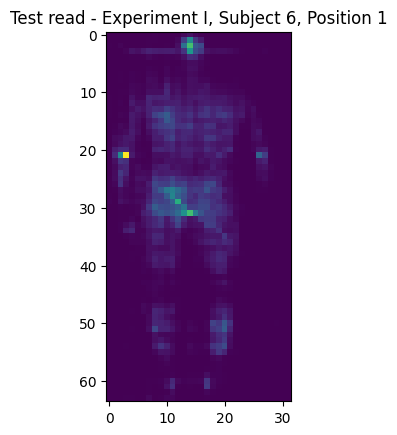

In [14]:
# Example of one sample
plt.title("Test read - Experiment I, Subject 6, Position 1")
plt.imshow(test_read[21,:].reshape(64, 32)) # 20th sample
plt.show()

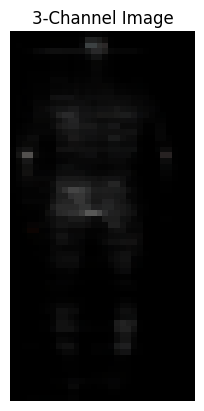

In [32]:
def create_3_channel_images(data, window_size=3):
    num_frames = data.shape[0]
    channels = []
    for i in range(num_frames - window_size + 1):
        # Stack 3 consecutive frames along the last axis to create a 3-channel image
        channel = np.stack(data[i:i+window_size], axis=-1)
        channels.append(channel)
    return np.array(channels)

test = create_3_channel_images(test_read)

median_data = ndimage.median_filter(test, size=(3, 3, 3))

norm_data = np.round(median_data * 255 / 1000).astype(np.uint8)

test_frame = norm_data[20].reshape(64, 32, 3)

plt.imshow(test_frame)
plt.title('3-Channel Image')
plt.axis('off')
plt.show()

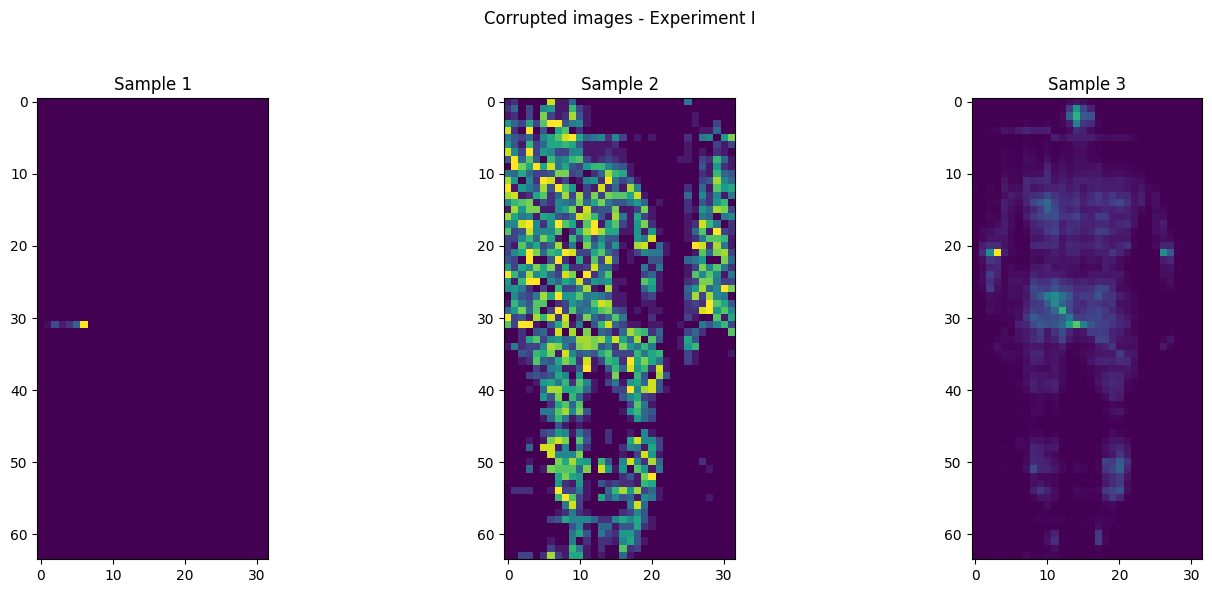

In [15]:
# Show that first three samples are corrupted
fig, axes = plt.subplots(figsize=(15, 6), ncols=3)
fig.suptitle("Corrupted images - Experiment I")

# Plot the first three samples
for ii in range(3):
    ax = axes[ii]
    ax.imshow(test_read[ii, :].reshape(64, 32))
    ax.set_title(f"Sample {ii+1}")


# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()


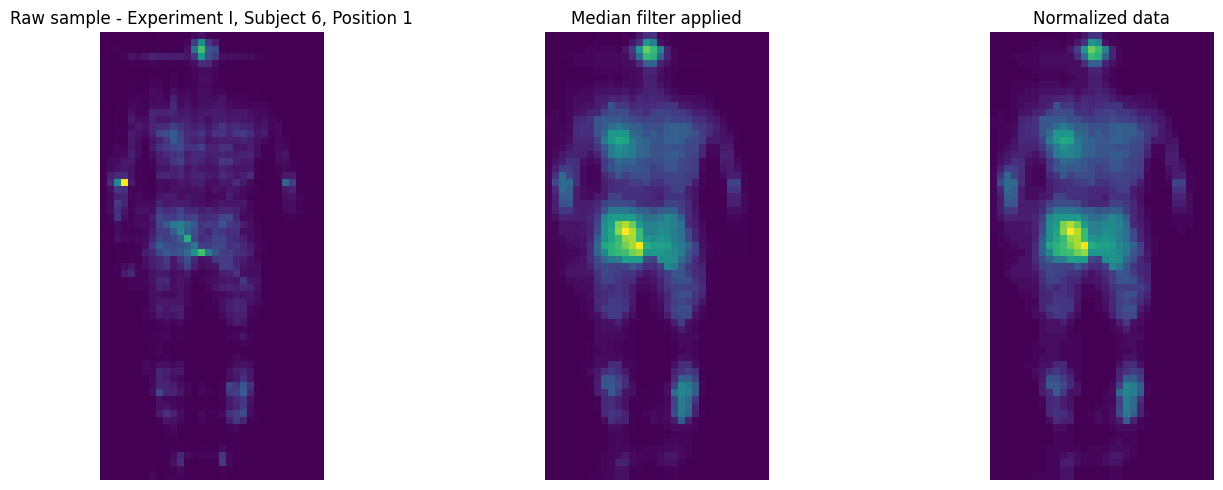

In [22]:
# Demonstrating the effect of preprocessing

# Read the sample data
raw_data = test_read[21, :].reshape(64, 32)
# Apply median filter
median_data = ndimage.median_filter(raw_data, size=(3, 3))
# Normalize the data: change range from [0-1000] to [0-255]
norm_data = np.round(median_data * 255 / 1000).astype(np.uint8)

# Create subplots to show each preprocessing step
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Raw sample
axes[0].imshow(raw_data)
axes[0].set_title("Raw sample - Experiment I, Subject 6, Position 1")
axes[0].axis('off')

# After median filter; he median filter generally preserves edges better than a Gaussian filter.
axes[1].imshow(median_data)
axes[1].set_title("Median filter applied")
axes[1].axis('off')

# After normalization
axes[2].imshow(norm_data)
axes[2].set_title("Normalized data")
axes[2].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [33]:
# Load all the data into a dictionary, where the keys are the subjects and 
# values: images (index 0), position's number (index 1), and specific position's name (index 2)

# Initialize dictionary to store the data
exp_i_data = {}

# Directory structure: /data/experiment-i/subject/position.txt
for _, dirs, _ in os.walk(path + '/data/experiment-i/'):  
    # Loop through each subject
    for dir in dirs:
        subject = dir
        data = None
        labels = None
        # Loop through each position file in the subject's directory
        for _, _, files in os.walk(path + '/data/experiment-i/' + dir):
            for file in files:
                # Posture path
                file_path = path + '/data/experiment-i/' + dir + '/' + file
                with open(file_path, 'r') as f:
                    # We remove first and last 3 corrupted frames - suggestion from the dataset's authors
                    for line in f.read().splitlines()[3:-3]:
                        raw_data = np.fromstring(line, dtype=float, sep='\t').reshape(1, 64, 32)
                        # apply median filter of 3x3
                        raw_data = ndimage.median_filter(raw_data, size=(1,3,3))
                        # Normalize the data: change range from [0-1000] to [0-255]
                        file_data = np.round(raw_data*255/1000).astype(np.uint8)
                        # Label the data using position number from file name
                        file_label = token_position(positions_i[int(file[:-4])])                        
                        file_label = np.array([file_label])

                        # Specific position label
                        position_label = positions_ii[int(file[:-4])]
                        position_label = np.array([position_label])

                        # Tokenize the position index
                        position_index = int(file[:-4])-1
                        position_index = np.array([position_index])

                        if data is None:
                            data = file_data
                        else:
                            # Concatenate the new data along the first axis
                            data = np.concatenate((data, file_data), axis=0)
                        if labels is None:
                            labels = file_label
                            positions = position_label
                            position_indices = position_index
                        else:
                            labels = np.concatenate((labels, file_label), axis=0)
                            positions = np.concatenate((positions, position_label), axis=0)
                            position_indices = np.concatenate((position_indices, position_index), axis=0)
                        
        exp_i_data[subject] = {'data': data, 'labels': labels, 'position_indices': position_indices, 'positions': positions}

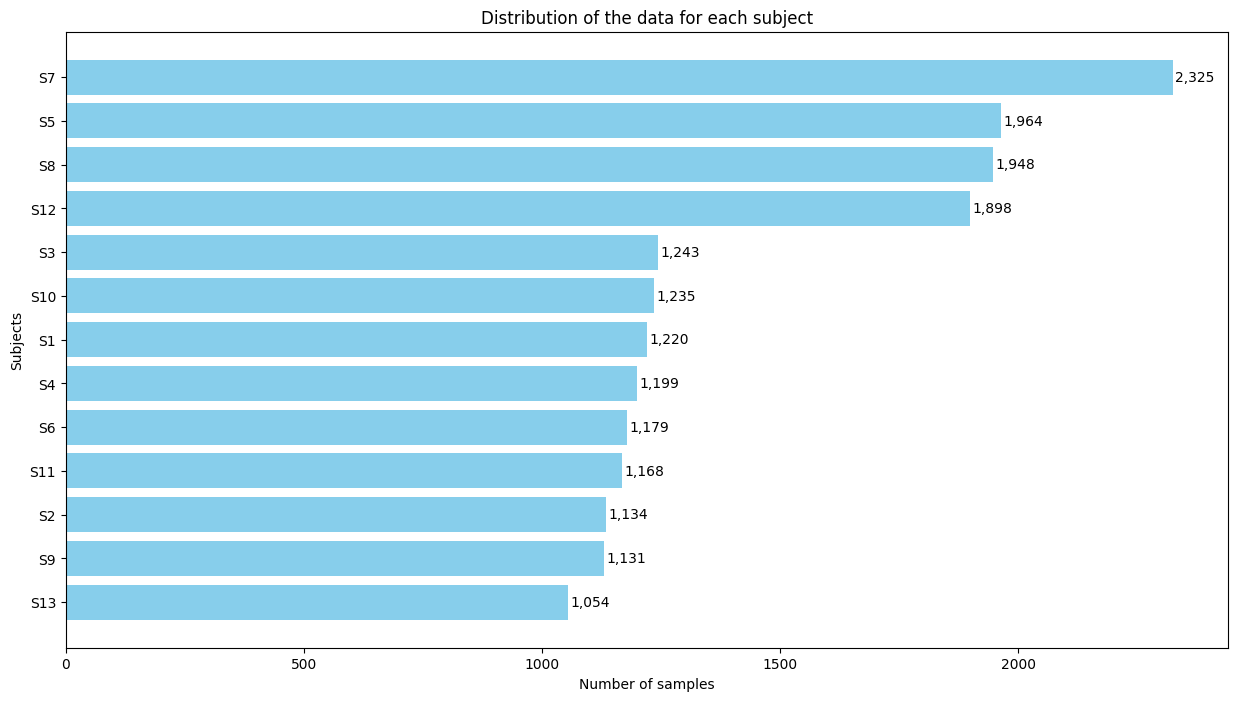

In [15]:
# Distribution of the data for each subjects

data_counts = {}

for subject, data in exp_i_data.items():
    data_counts[subject] = data['data'].shape[0]

sorted_subjects = sorted(data_counts.items(), key=lambda item: item[1])

# Plot the distribution of the data
plt.figure(figsize=(15, 8))
bars = plt.barh([subj for subj, count in sorted_subjects], [count for subj, count in sorted_subjects], color='skyblue')

# Add the value at the end of each bar
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,}', va='center', color='black')
plt.xlabel('Number of samples')
plt.ylabel('Subjects')
plt.title('Distribution of the data for each subject')
plt.show()


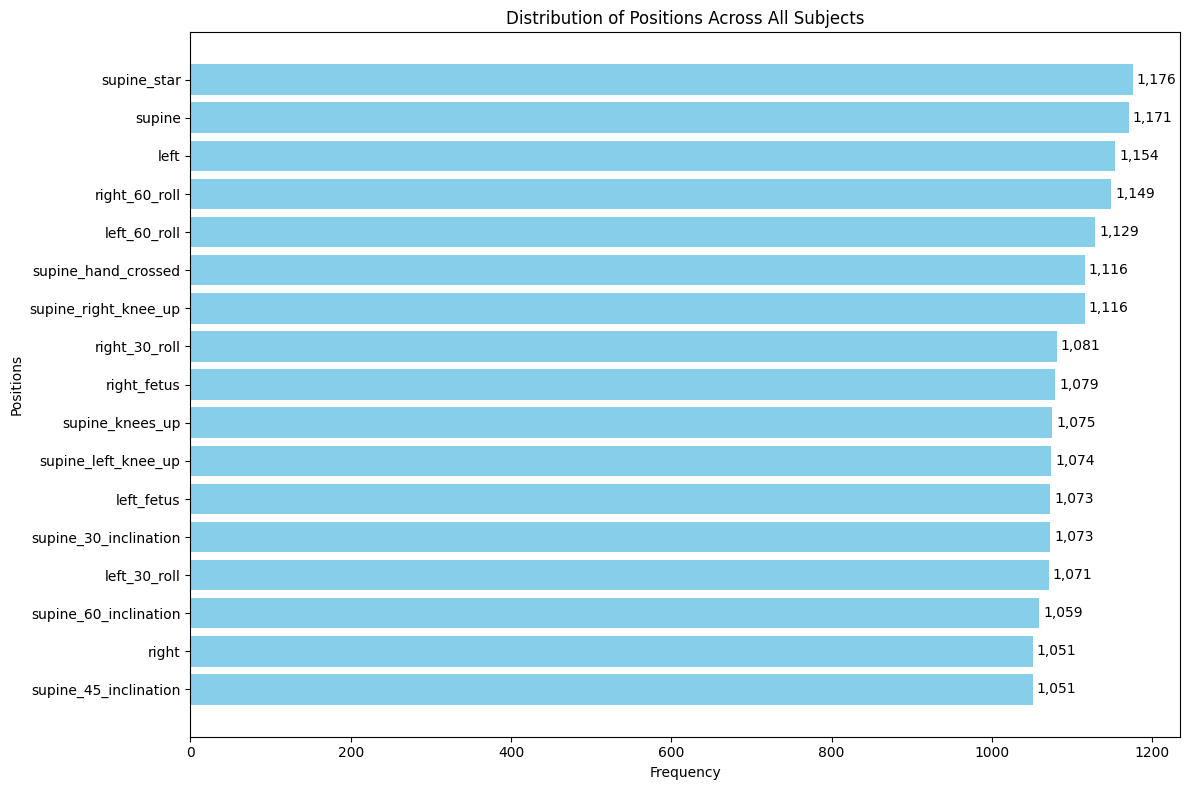

In [16]:
# Show the distribution of the positions across the subjects

position_counts = Counter()

for subject_data in exp_i_data.values():
    position_counts.update(subject_data['positions'])

# Sort positions by count in descending order
sorted_positions_counts = sorted(position_counts.items(), key=lambda item: item[1])
positions, counts = zip(*sorted_positions_counts)

# Plot the distribution of positions
plt.figure(figsize=(12, 8))
bars = plt.barh(positions, counts, color='skyblue')

# Add values at the end of each bar
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,}', va='center', color='black')

plt.xlabel('Frequency')
plt.ylabel('Positions')
plt.title('Distribution of Positions Across All Subjects')
plt.tight_layout()
plt.show()



#### Train-Test Split

In [34]:
# Create datasets for each task

def create_dataset(ylabel):
    X = exp_i_data[subj_list[0]]['data']
    y = exp_i_data[subj_list[0]][ylabel] 
    label_s = np.full(len(X), token_patient(subj_list[0]))

    for subject in subj_list[1:]:
        X = np.append(X, exp_i_data[subject]['data'], axis=0)
        y = np.append(y, exp_i_data[subject][ylabel], axis=0)
        label_s = np.append(label_s, np.full(len(exp_i_data[subject]['data']), token_patient(subject)))
    return X, y, label_s

In [35]:
# Task 1: Predict the macro position (supine, left, right), ylabel = 'labels'
# Task 2: Predict the specific position (17 positions), ylabel = 'position_indices'
X, y, label_s = create_dataset('position_indices')

In [36]:
print(X.shape, y.shape, label_s.shape)

(18698, 64, 32) (18698,) (18698,)


In [50]:
# Train-Test Split

# 70% training set, 20% validation set and 10% test set

# Experiment I
indices = np.arange(len(X))
X_train_val, X_test, y_train_val, y_test, indices_train_val, indices_test, = train_test_split(X, y, indices, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train_val, y_train_val, indices_train_val, test_size=0.2222, random_state=123)

# Split label_s accordingly using indices
label_s_train = label_s[indices_train]
label_s_val = label_s[indices_val]
label_s_test = label_s[indices_test]

# Print number of samples in each set
print(f"Number of samples in training set: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Number of samples in validation set: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Number of samples in test set: {len(X_test)} ({len(X_test)/len(X):.2%})")

Number of samples in training set: 13088 (70.00%)
Number of samples in validation set: 3740 (20.00%)
Number of samples in test set: 1870 (10.00%)


In [51]:
# One-hot encode the labels
label_s_train = tf.keras.utils.to_categorical(label_s_train, num_classes=13)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=17)
label_s_val = tf.keras.utils.to_categorical(label_s_val, num_classes=13)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=17)
label_s_test = tf.keras.utils.to_categorical(label_s_test, num_classes=13)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=17)

### Model Definition

In [53]:
# Define the proposed model from paper

# can't use a sequential model as model has multiple outputs
#each convolutional block was followed by an increasing dropout rate of 10%, 20%, 30%, 40%. 

# Define the functional model
def create_model(regularization=0):

    input = tf.keras.Input(shape=(64, 32, 1), name="img")
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1,1), padding='valid', kernel_regularizer=l2(regularization))(input)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.GlobalMaxPool2D()(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    subject_output = tf.keras.layers.Dense(13, activation='softmax', name="subject_output")(x)
    posture_output = tf.keras.layers.Dense(17, activation='softmax', name="posture_output")(x)

    base_cnn_model = tf.keras.Model(inputs=input, outputs=[subject_output,posture_output], name="base_cnn_model")

    return base_cnn_model
    # From Figure 2 in paper

    # Input: 32x64x1

    # 4 main blocks of conv-batchnorm plus max pool for 1st 2 blocks
    # 1st block: 30 x 62 x 32 of conv-batchnorm-maxpool-leakyrelu (32 filters applied), max pool would make each 30x 62 =10 x 20, cov would make (32-3+1)x(64-3+1) = 30 x 62
    # 2nd block: 13 x 29 x 64 of conv-batchnorm-maxpool-leakyrelu
    # 3rd block: 4 x 12 x 128 of conv-batchnorm-leakyrelu
    # 4th block: 2 x 10 x 256 of conv-batchnorm-leakyrelu

    # Two Dense layers of 256 units with dropout of 0.5
    # Two output layers, multinomial logistic regressors for recognition of subjects (M units) and their sleep postures (N units)

    # Loss function: multiclass cross-entropy loss function of subjects and users separately
    # plus combined loss function of both with hyperparameter lambda (from 0 to 1)

    # Conv kernels: 3x3, stride 1, padding valid
    # Max pool: 3x3
    # batch norm
    # Leaky ReLU: alpha 0.2

    # dense layers have dropout of 0.5

    # each conv block was followed by increasing drop of .1, .2, .3, .4

    # L2 reg loss with coefficient of 0.002
    # 2 softmax regressors

In [83]:
# Preprocessing

# median filter of 3x3
# remove first and last 3 frames of each sequence
# threshold filtering and equalization histogram

### Loss Functions for Training

### Notation
- Let $I$ be the input pressure map.
- Let $i$ be the example index.
- Let $\gamma$ and $\delta$ be the user and the posture, respectively
- Let M and N be the number of users and postures, respectively

### Multi-Class Cross Entropy Loss Functions

User Loss:

$$ L_{user} = - \sum_{j=1}^{M} \gamma_{ij} \log P({\gamma_{j}}|I_i)$$


Posture Loss:

$$ L_{posture} = - \sum_{j=1}^{N} \delta_{ij} \log P({\delta_{j}}|I_i)$$

Combined Loss

$$ L = \lambda L_{user} + (1-\lambda)L_{posture} $$

where $\lambda$ is a hyperparameter that enforces the tradeoff between the two objectives - separating users and detecting postures

In [54]:
def custom_loss(lambd):
    # Define separate loss functions for each output
    def user_loss(y_true, y_pred):
        return tf.keras.losses.categorical_crossentropy(y_true[0], y_pred[0])

    def posture_loss(y_true, y_pred):
        return tf.keras.losses.categorical_crossentropy(y_true[1], y_pred[1])

    # Combine the losses with the specified lambda
    def combined_loss(y_true, y_pred):
        return lambd * user_loss(y_true, y_pred) + (1 - lambd) * posture_loss(y_true, y_pred)
    return combined_loss

### Model Training

In [55]:
# Parameters
learning_rate = 5e-4
epochs = 40
batch_size = 32
regularization = 0
model_name = 'base_cnn_model'
lambda_val = 0.5

model_performance = pd.DataFrame(index=['Test Subject Accuracy', 'Test Posture Accuracy', 'Training Time (s)', 'Parameters', 'Model Size (MB)'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Define the model
model = create_model(regularization)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer = optimizer,
        loss=custom_loss(lambda_val),
        metrics=[tf.keras.metrics.CategoricalAccuracy()])

# Capture the training time
start_time = time.time()

# Train the model
history = model.fit(
                X_train, 
                {
                'subject_output': label_s_train, 
                'posture_output': y_train
                 },
                epochs=epochs, 
                batch_size=batch_size, 
                validation_split=0.1, 
                validation_data=(
                        X_val, 
                        {
                        'subject_output': label_s_val, 
                        'posture_output': y_val
                        }
                ),
                callbacks=[early_stop_callback]
                )

# Capture the end time
end_time = time.time()

# Calculate the elapsed time
training_time = end_time - start_time

# Record the model performance
model_val_subject_acc = history.history['val_subject_output_categorical_accuracy'][-1]
model_val_posture_acc = history.history['val_posture_output_categorical_accuracy'][-1]
num_parameters = int(model.count_params())

# Save the model
model.save(path + f'/models/{model_name}.h5')

# save model size
model_size = os.path.getsize(path + f'/models/{model_name}.h5')
model_size_kb = model_size / 1024
model_size_mb = model_size_kb / 1024

# add new entry to model performance
model_performance[model_name] = [
                                np.round(model_val_subject_acc, 3), 
                                np.round(model_val_posture_acc, 3), 
                                np.round(training_time, 3), 
                                int(num_parameters), 
                                np.round(model_size_mb, 3)]




Epoch 1/40


2024-07-01 18:57:43.251693: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


409/409 [==============================] - 5s 6ms/step - loss: 6.3380 - subject_output_loss: 3.1369 - posture_output_loss: 3.2011 - subject_output_categorical_accuracy: 0.1131 - posture_output_categorical_accuracy: 0.1101 - val_loss: 5.1251 - val_subject_output_loss: 2.4771 - val_posture_output_loss: 2.6481 - val_subject_output_categorical_accuracy: 0.1888 - val_posture_output_categorical_accuracy: 0.1727
Epoch 2/40
409/409 [==============================] - 3s 6ms/step - loss: 5.1814 - subject_output_loss: 2.5840 - posture_output_loss: 2.5974 - subject_output_categorical_accuracy: 0.1359 - posture_output_categorical_accuracy: 0.1750 - val_loss: 5.0066 - val_subject_output_loss: 2.4737 - val_posture_output_loss: 2.5329 - val_subject_output_categorical_accuracy: 0.1842 - val_posture_output_categorical_accuracy: 0.2845
Epoch 3/40
409/409 [==============================] - 2s 6ms/step - loss: 4.9371 - subject_output_loss: 2.5472 - posture_output_loss: 2.3899 - subject_output_categorical_a

In [56]:
model_performance

# Model with Identifying 3 postures: test subj accuracy: 0.327, test posture accuracy: 0.998, training time: 40.847, parameters: 525456, model size: 6.121 MB

# Model with Identifying 17 postures: test subj accuracy: 0.5698, test posture accuracy: 0.8746, training time: 101.416, parameters: 529054, model size: 6.162 MB

,base_cnn_model
Test Subject Accuracy,0.570
Test Posture Accuracy,0.875
Training Time (s),101.416
Parameters,529054.000
Model Size (MB),6.162


## Final Model Testing

In [92]:
print(f'Predict the classification of {X_test.shape[0]} samples')
y_pred_subject, y_pred_posture = model.predict(X_test)

# Determine the predicted classes using argmax
y_pred_posture = np.argmax(y_pred_posture, axis=1)
y_pred_subject = np.argmax(y_pred_subject, axis=1)

Predict the classification of 1870 samples
20/59 [=========>....................] - ETA: 0s

59/59 [==============================] - 0s 3ms/step


### Confusion Matrices

In [93]:
# Sort position labels: left, right, supine

positions_ii_sorted = ['left', 'left_30_roll', 'left_60_roll', 'left_fetus', 
                       'right', 'right_30_roll', 'right_60_roll', 'right_fetus', 
                       'supine', 'supine_star', 'supine_hand_crossed', 'supine_knees_up', 'supine_right_knee_up', 'supine_left_knee_up',  
                       'supine_30_inclination', 'supine_45_inclination', 'supine_60_inclination']

# indices of the sorted positions
positions_ii_sorted_indices = [positions_ii.index(position)-1 for position in positions_ii_sorted]

In [94]:
# Extract true labels of posture and subject
y_true = np.argmax(y_test, axis=1)
label_s_true = np.argmax(label_s_test, axis=1)

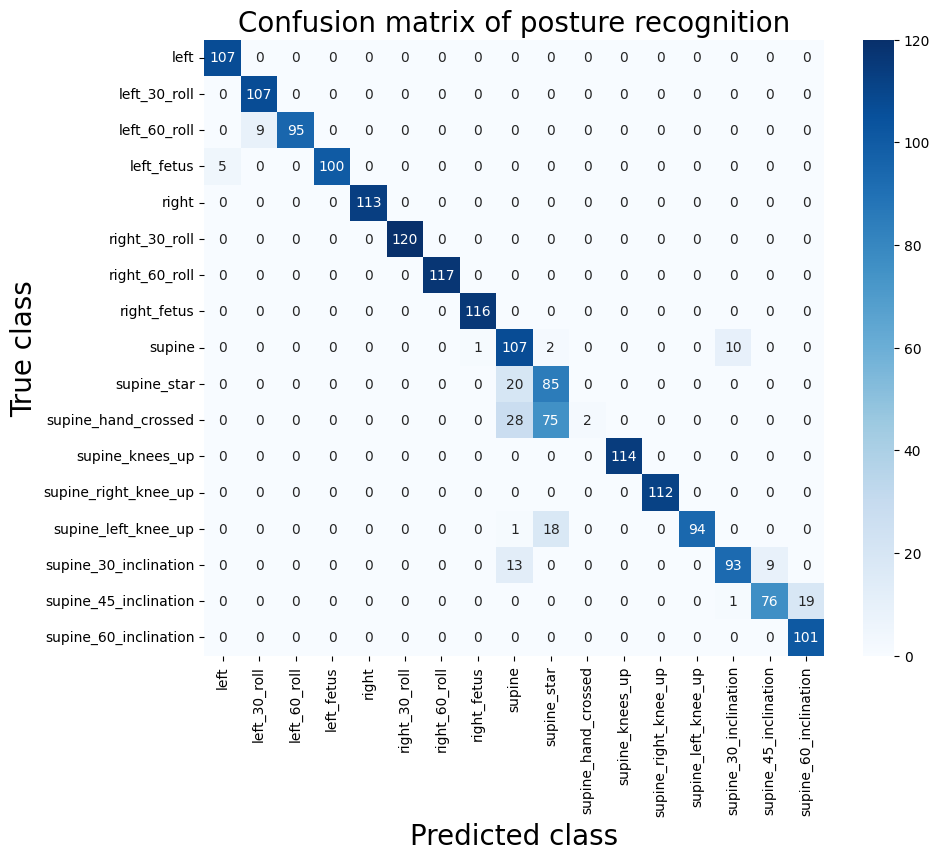

In [95]:
posture_cm = confusion_matrix(y_true=y_true, y_pred=y_pred_posture, labels=positions_ii_sorted_indices)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(posture_cm, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(positions_ii_sorted, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True class', fontsize=20)
ax.yaxis.set_ticklabels(positions_ii_sorted, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion matrix of posture recognition', fontsize=20)

plt.show()
     

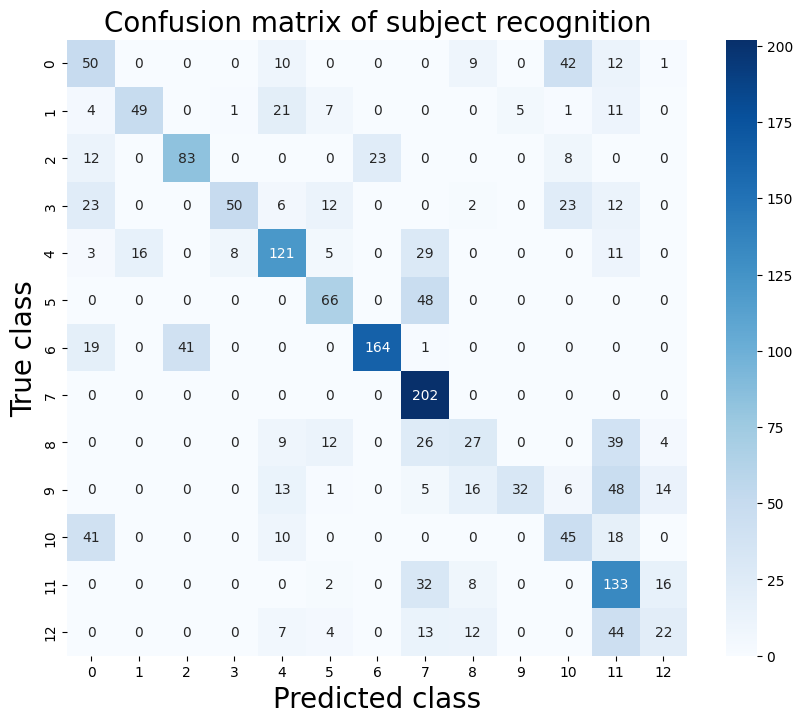

In [96]:
subject_cm = confusion_matrix(y_true=label_s_true, y_pred=y_pred_subject)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(subject_cm, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.set_ylabel('True class', fontsize=20)
plt.title('Confusion matrix of subject recognition', fontsize=20)
plt.show()

### Performance Metrics - Accuracy, Recall, Precision, F1-Score

In [97]:
# Accuracy, Precision, Recall, F1-Score
posture_accuracy = accuracy_score(y_true, y_pred_posture)
subject_accuracy = accuracy_score(label_s_true, y_pred_subject)

posture_precision, posture_recall, posture_fscore, _ = precision_recall_fscore_support(y_true, y_pred_posture)
subject_precision, subject_recall, subject_fscore, _ = precision_recall_fscore_support(label_s_true, y_pred_subject)

# Create a DataFrame to display the results
results = pd.DataFrame(index=['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score'])

# Add the results to the DataFrame
results['Posture'] = [np.round(posture_accuracy,3), 
                      np.round(np.mean(posture_precision),3), 
                      np.round(np.mean(posture_recall),3), 
                      np.round(np.mean(posture_fscore),3)]

results['Subject'] = [np.round(subject_accuracy,3),
                      np.round(np.mean(subject_precision),3),
                      np.round(np.mean(subject_recall),3),
                      np.round(np.mean(subject_fscore),3)]

results

,Posture,Subject
Accuracy (%),0.887,0.558
Precision (%),0.918,0.588
Recall (%),0.883,0.512
F1-Score,0.868,0.516


### K-Fold Cross Validation

In [135]:
# One-hot encode the labels

label_s_oh = tf.keras.utils.to_categorical(label_s, num_classes=13)
y_oh = tf.keras.utils.to_categorical(y, num_classes=3)

In [ ]:
# K-Fold Cross Validation on best model

initial_learning_rate = 5e-4
epochs = 40
batch_size = 32
regularization = 0
model_name = 'best_model'

lambda_performance = pd.DataFrame(index=['Test Subject Accuracy', 'Test Posture Accuracy', 'Training Time (s)'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

skf = StratifiedKFold(n_splits=10, shuffle=True)

lambdas = [0.2, 0.5, 0.6, 0.8]

performances = {lambd: [] for lambd in lambdas}
for lambd in lambdas:
    performances[lambd] = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Lambda: {lambd} Fold {i}:")
        model=create_model(regularization) # For now, this is the best model
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        model.compile(optimizer = optimizer,
                loss=custom_loss(lambd),
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

        start_time = time.time()

        history = model.fit(
            X[train_index], 
            {
                'subject_output': label_s_oh[train_index], 
                'posture_output': y_oh[train_index]
            },
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(
                X[test_index], 
                {
                    'subject_output': label_s_oh[test_index], 
                    'posture_output': y_oh[test_index]
                }
            ),
            callbacks=[early_stop_callback]
        )

        end_time = time.time()
        training_time = end_time - start_time
        
        # Record the model performance per fold and lambda
        performances[lambd].append([
                                    history.history["val_subject_output_categorical_accuracy"], 
                                    history.history["val_posture_output_categorical_accuracy"],
                                    training_time
                                    ])


# mean performances for each lamda on subject [0] or posture [1] accuracy
for lambd in lambdas:
    subject_accuracies = [perf[0] for perf in performances[lambd]]
    posture_accuracies = [perf[1] for perf in performances[lambd]]
    training_times = [perf[2] for perf in performances[lambd]]
    
    # Calculate the maximum accuracy for each fold
    max_subject_accuracies = [np.max(fold_accuracies) for fold_accuracies in subject_accuracies]
    max_posture_accuracies = [np.max(fold_accuracies) for fold_accuracies in posture_accuracies]
    
    # Calculate the mean of these maximum accuracies
    mean_max_subject_accuracy = np.round(np.mean(max_subject_accuracies), 3)
    mean_max_posture_accuracy = np.round(np.mean(max_posture_accuracies), 3)
    mean_training_time = np.round(np.mean(training_times), 3)
    
    # Append the results to the DataFrame
    lambda_performance[lambd] = [mean_max_subject_accuracy, mean_max_posture_accuracy,mean_training_time]

In [141]:
lambda_performance

,0.2,0.5,0.6,0.8
Test Subject Accuracy,0.431,0.508,0.497,0.403
Test Posture Accuracy,0.998,1.000,0.999,0.998
Training Time (s),37.357,56.645,53.775,47.274
